# Model & Evaluation

## 1. Load Packages and Datasets

In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score
import time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [2]:
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [3]:
# Load pre-processed train and test set from EDA notebook
train_df = pd.read_json('./../data/preprocess_train.json')
test_df = pd.read_json('./../data/preprocess_test.json')

raw_train_df = pd.read_json('./../data/train.json')
raw_test_df = pd.read_json('./../data/test.json')

## 2. Model Building

In [4]:
# Convert list of tokens back to strings
train_df['tokens_joined'] = train_df['tokens_processed'].apply(lambda tokens: ' '.join(tokens))

# Extract features and labels
X = train_df['tokens_joined']
y = train_df['labels_processed']

mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y)

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

# Train-valid split
X_train, X_valid, y_train, y_valid = train_test_split(X_tfidf, y_bin, test_size=0.2, random_state=599)

# Used for models that require 1D train/validation
y_train_argmax = np.argmax(y_train, axis=1)
y_valid_argmax = np.argmax(y_valid, axis=1)

In [5]:
# Verify shape of dataset
print("Shape of X_train:", X_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_valid:", y_valid.shape)

Shape of X_train: (5445, 37843)
Shape of X_valid: (1362, 37843)
Shape of y_train: (5445, 13)
Shape of y_valid: (1362, 13)


In [6]:
# Create function to run classification report and collect performance metrics
def evaluate(y, y_pred):
    accuracy = round(accuracy_score(y, y_pred), 2)
    print('Accuracy Score:', accuracy, '\n')

    report = classification_report(y, y_pred)
    print('Classification Report:')
    print(report)

### 2.1 Logistic Regression Model

In [7]:
start_time = time.time()

logreg_model = LogisticRegression(max_iter=1000, random_state=599)
logreg_model.fit(X_train, y_train_argmax)

y_pred_logreg = logreg_model.predict(X_valid)

end_time = time.time()

In [8]:
runtime_lg = end_time - start_time
print("Model runtime:", runtime_lg, "seconds")
evaluate(y_valid_argmax, y_pred_logreg)

Model runtime: 2.4524049758911133 seconds
Accuracy Score: 0.86 

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00       168
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         2
          12       0.86      1.00      0.93      1172

    accuracy                           0.86      1362
   macro avg       0.12      0.14      0.13      1362
weighted avg       0.74      0.86      0.80      1362



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.2 Random Forest Model
#### 2.2.1 Using 100 Estimators

In [9]:
start_time = time.time()

# Baseline model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=599)
rf_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf = rf_classifier.predict(X_valid)

end_time = time.time()

In [10]:
runtime_rf = end_time - start_time
print("Model runtime:", runtime_rf, "seconds")
evaluate(y_valid, y_pred_rf)

Model runtime: 15.482578039169312 seconds
Accuracy Score: 0.86 

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        12
           2       1.00      0.01      0.01       183
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00       169
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       1.00      1.00      1.00      1362

   micro avg       1.00      0.78      0.88      1744
   macro avg       0.15      0.08      0.08      1744
weighted avg       0.89      0.78      0.78   

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 2.2.2 Parameter Tuning with GridSearch

In [11]:
# Hyperparameter tuning for RF
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
start_time = time.time()

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=599)
rf_classifier.fit(X_train, y_train)

# Grid search model
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, n_jobs=-1,
                           cv=3, verbose=2, scoring='f1')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

Best parameters found:  {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


In [12]:
final_rf_model = RandomForestClassifier(**best_params)
final_rf_model.fit(X_train, y_train)

# Make predictions on the validation set
pred_rf_grid = rf_classifier.predict(X_valid)

end_time = time.time()

In [13]:
# Evaluate the model
runtime_rf_grid = end_time - start_time
print("Model runtime:", runtime_rf_grid, "seconds")
evaluate(y_valid, pred_rf_grid)

Model runtime: 252.79555892944336 seconds
Accuracy Score: 0.86 

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        12
           2       1.00      0.01      0.01       183
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00       169
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       1.00      1.00      1.00      1362

   micro avg       1.00      0.78      0.88      1744
   macro avg       0.15      0.08      0.08      1744
weighted avg       0.89      0.78      0.78   

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.3 K-Nearest Neighbors Model

#### 2.3.1 Tuning with K Parameter

In [14]:
# Tuning K Parameter
train_score = {}
valid_score = {}
n_neighbors = np.arange(2, 30, 1) #2-29 neighbors

start_time = time.time()
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_score[neighbor]=knn.score(X_train, y_train)
    valid_score[neighbor]=knn.score(X_valid, y_valid)

In [15]:
for best_k, value in valid_score.items():
    if value==max(valid_score.values()):
        print("Optimal K:", best_k)

Optimal K: 10
Optimal K: 11


In [16]:
knn_classifier = KNeighborsClassifier(n_neighbors=10)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_knn = knn_classifier.predict(X_valid)
end_time = time.time()

In [17]:
# Evaluate the model
runtime_knn = end_time - start_time
print("Model runtime:", runtime_knn, "seconds")
evaluate(y_valid, y_pred_knn)

Model runtime: 140.65211129188538 seconds
Accuracy Score: 0.86 

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.08      0.15        12
           2       1.00      0.01      0.01       183
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       1.00      0.01      0.01       169
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       1.00      1.00      1.00      1362

   micro avg       1.00      0.78      0.88      1744
   macro avg       0.31      0.08      0.09      1744
weighted avg       0.99      0.78      0.78   

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


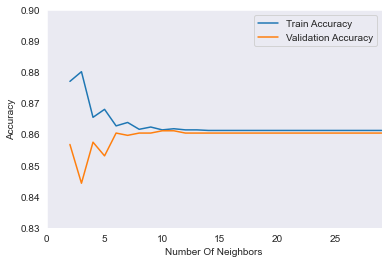

In [18]:
plt.plot(n_neighbors, train_score.values(), label="Train Accuracy")
plt.plot(n_neighbors, valid_score.values(), label="Validation Accuracy")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.legend()
plt.xlim(0, 29)
plt.ylim(0.83, 0.90)
plt.grid()
plt.show()

#### 2.3.2 Parameter Tuning with GridSearch

In [19]:
# Hyperparameter tuning with GridSearch
kf=KFold(n_splits=5,shuffle=True,random_state=42)
estimator_knn = KNeighborsClassifier(algorithm='auto')
param_grid_knn = {
    'n_neighbors': np.arange(2, 30, 1),
}

start_time = time.time()

# Instantiate GridSearchCV
grid_search_knn = GridSearchCV(estimator=estimator_knn,
                               param_grid=param_grid_knn,
                               verbose=1,
                               cv = kf)

# Perform grid search to find the best parameters
grid_search_knn.fit(X_train, y_train)

# Get the best parameters
print(grid_search_knn.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'n_neighbors': 10}


In [20]:
final_knn_model = KNeighborsClassifier(n_neighbors=10)

# Train the model on the training data
final_knn_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_knn_grid = final_knn_model.predict(X_valid)

end_time = time.time()

In [21]:
# Evaluate the model
runtime_knn_grid = end_time - start_time
print("Model runtime:", runtime_knn_grid, "seconds")
# Calculate accuracy
accuracy = accuracy_score(y_valid, y_pred_knn_grid)
print("Accuracy:", accuracy)

# Evaluate the model
print(classification_report(y_valid, y_pred_knn_grid))

Model runtime: 96.37739610671997 seconds
Accuracy: 0.8612334801762115
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      0.08      0.15        12
           2       1.00      0.01      0.01       183
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       1.00      0.01      0.01       169
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       1.00      1.00      1.00      1362

   micro avg       1.00      0.78      0.88      1744
   macro avg       0.31      0.08      0.09      1744
weighted avg       0.99      0.78      0.78      1744
 samples a

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 2.4 XGBoost Model

In [22]:
xgb_model = xgb.XGBClassifier()
y_train_argmax = np.argmax(y_train, axis=1)
y_valid_argmax = np.argmax(y_valid, axis=1)

xgb_model.fit(X_train, y_train_argmax)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:42:40] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0]
}
start_time = time.time()
# Randomized search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                n_iter=10, cv=3, verbose=2, random_state=599, n_jobs=-1)

# Find best parameters
random_search.fit(X_train, y_train_argmax)
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting wi

[14:54:38] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters found:  {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01}


In [24]:
from xgboost import XGBClassifier

final_xgb_model = XGBClassifier(**best_params)
final_xgb_model.fit(X_train, y_train_argmax)

# Make predictions on the validation set
y_pred_xgb = final_xgb_model.predict(X_valid)

end_time = time.time()

[14:55:18] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
# Evaluate the model
runtime_xgb = end_time - start_time
print("Model runtime:", runtime_xgb, "seconds")
evaluate(y_valid, y_pred_xgb)

Model runtime: 781.8271389007568 seconds


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

## 3. Evaluate Models

In [36]:
# Store runtime results
model_names = ['Logistic Regression',
               'Random Forest',
               'Random Forest - GridSearch',
               'K-Nearest Neighbors',
               'K-Nearest Neighbors - GridSearch',
               'XGBoost - RandomSearch']
model_runtime = [runtime_lg,
                 runtime_rf,
                 runtime_rf_grid,
                 runtime_knn,
                 runtime_knn_grid,
                 runtime_xgb]

runtime_df = pd.DataFrame({'Model': model_names,
                           'Runtime (seconds)': model_runtime})

# Round the runtimes to two decimal places
runtime_df['Runtime (seconds)'] = round(runtime_df['Runtime (seconds)'], 2)
runtime_df = runtime_df.sort_values(by=['Runtime (seconds)'])
runtime_df

,Model,Runtime (seconds)
0,Logistic Regression,2.45
1,Random Forest,15.48
4,K-Nearest Neighbors - GridSearch,96.38
3,K-Nearest Neighbors,140.65
2,Random Forest - GridSearch,252.80
5,XGBoost - RandomSearch,781.83


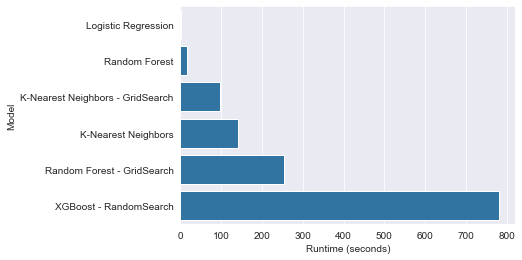

In [37]:
sns.barplot(runtime_df, y='Model', x='Runtime (seconds)')
plt.show()